In [1]:
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import os
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')
## "Reference: https://github.com/silpara/simulators/tree/master/compartmental_models"

In [2]:
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, ToggleButton

style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [3]:
# !pip3 install lmfit
!pip install plotly

In [4]:
data = pd.read_csv('caso_full.csv')
mapping = {}
mapping['AC'] = "Norte"
mapping['AL'] = "Nordeste"
mapping['AM'] = "Norte"
mapping['AP'] = "Norte"
mapping['BA'] = "Nordeste"
mapping['CE'] = "Nordeste"
mapping['DF'] = "Centro Oeste"
mapping['ES'] = "Sudeste"
mapping['GO'] = "Centro Oeste"
mapping['MA'] = "Nordeste"
mapping['MG'] = "Sudeste"
mapping['MS'] = "Centro Oeste"
mapping['MT'] = "Centro Oeste"
mapping['PA'] = "Norte"
mapping['PB'] = "Nordeste"
mapping['PE'] = "Nordeste"
mapping['PI'] = "Nordeste"
mapping['PR'] = "Sul"
mapping['RJ'] = "Sudeste"
mapping['RN'] = "Nordeste"
mapping['RO'] = "Centro Oeste"
mapping['RR'] = "Norte"
mapping['RS'] = "Sul"
mapping['SC'] = "Sul"
mapping['SE'] = "Nordeste"
mapping['SP'] = "Sudeste"
mapping['TO'] = "Norte"
field = "last_available_confirmed"
data = data[(data['city'].isnull() == False) & (data['is_repeated'] == False)]
columns_to_drop = ['city','place_type',
                   'last_available_date','estimated_population',
                   'is_last','is_repeated']
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data['region'] = data.apply (lambda row: mapping[row["state"]], axis=1)
pop_estimation = data[["estimated_population","region"]].groupby("region").sum()
data.drop(columns=columns_to_drop,inplace=True)
min_date = data["date"].min()
max_date = data["date"].max()
delta = max_date - min_date
dates = pd.date_range(start=min_date, end=max_date, freq='D')
def interpolate_mun(mun_data,field):
    series = mun_data[[field,"date","region"]]
    region_ = series.iloc[0].region
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    series["region"] = region_
    return series
l = ["Centro Oeste","Nordeste","Norte","Sudeste","Sul"]

In [5]:
agg_data = data[[field,"city_ibge_code","region","date"]]\
                            .groupby("city_ibge_code")\
                            .apply(lambda x: interpolate_mun(x,field))
agg_data["deaths"] = data[["new_deaths","city_ibge_code","region","date"]]\
                            .groupby("city_ibge_code")\
                            .apply(lambda x: interpolate_mun(x,"new_deaths"))["new_deaths"]
agg_data = agg_data.reset_index()
agg_data.rename(columns={"level_1": "date"},inplace=True)
agg_data = agg_data[[field,"deaths","region","date"]].groupby(['region',"date"]).sum()
grouped = agg_data.reset_index().groupby("region")
infected = np.zeros((len(grouped),delta.days + 1))
deaths = np.zeros((len(grouped),delta.days + 1))
for i,(group, data_) in enumerate(grouped):
    series = data_[[field,"date"]]
    print(i,group)
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    infected[i,:] = series.values.reshape(len(series))
    series = data_[["deaths","date"]]
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    deaths[i,:] = series.values.reshape(len(series))

0 Centro Oeste
1 Nordeste
2 Norte
3 Sudeste
4 Sul


In [6]:
agg_data

last_available_confirmed  deaths
region       date                                        
Centro Oeste 2020-02-25                       0.0     0.0
             2020-02-26                       0.0     0.0
             2020-02-27                       0.0     0.0
             2020-02-28                       0.0     0.0
             2020-02-29                       0.0     0.0
...                                           ...     ...
Sul          2021-10-03                 4125492.0    81.0
             2021-10-04                 4125929.0    85.0
             2021-10-05                 4127195.0    96.0
             2021-10-06                 4128203.0    88.0
             2021-10-07                 4129237.0    88.0

[2955 rows x 2 columns]

In [7]:
dim = int(np.floor(infected.shape[1]/7))
Y = np.zeros(( 5, dim))
D = np.zeros((5,dim))
for t in range(dim):
    for i in range(5):
        if t < dim - 1:
            Y[i,t] = infected[i,7*t+7] - infected[i,7*t]
            D[i,t] = np.sum(deaths[i,7*t:7*t+7])
        else:
            Y[i,t] = infected[i,-1]- infected[i,7*t]
            D[i,t] = np.sum(deaths[i,7*t:])

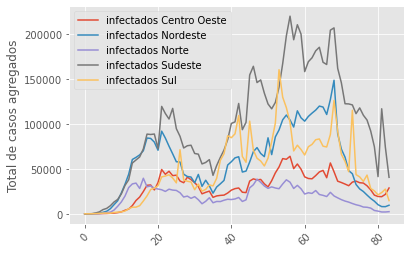

In [8]:
for i in range(5):
    plt.plot(Y[i,:],label=f"infectados {l[i]}")
#     plt.plot(D[i,:],label=f"mortes {l[i]}")
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [9]:
def ode_model(z, t, beta, sigma, gamma):
    """
    Reference https://www.idmod.org/docs/hiv/model-seir.html
    """
    S, E, I, R = z
    N = S + E + I + R
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I
    dRdt = gamma*I
    return [dSdt, dEdt, dIdt, dRdt]

def ode_solver(t, initial_conditions, params):
    initE, initI, initR, initN = initial_conditions
    beta, sigma, gamma = params['beta'].value, params['sigma'].value, params['gamma'].value
    initS = initN - (initE + initI + initR)
    res = odeint(ode_model, [initS, initE, initI, initR], t, args=(beta, sigma, gamma))
    return res

In [16]:
pop_estimation/=1e3
pop_estimation.iloc[0]

estimated_population    9322173.31
Name: Centro Oeste, dtype: float64

In [35]:
initN = pop_estimation.iloc[0]
initE = 1000
initI = 47
initR = 0
sigma = 1/5.2
gamma = 1/2.9
R0 = 4
beta = R0 * gamma
days = Y.shape[1]
params = Parameters()
params.add('beta', value=beta, min=0, max=10)
params.add('sigma', value=sigma, min=0, max=10)
params.add('gamma', value=gamma, min=0, max=10)

In [36]:
df = pd.DataFrame.from_dict({"infected":infected[i,:],"total_recovered_or_dead":deaths[i,:]})

# Simulation

In [37]:
def main(initE, initI, initR, initN, beta, sigma, gamma, days, param_fitting):
    initial_conditions = [initE, initI, initR, initN]
    params['beta'].value, params['sigma'].value,params['gamma'].value = [beta, sigma, gamma]
    tspan = np.arange(0, days, 1)
    sol = ode_solver(tspan, initial_conditions, params)
    S, E, I, R = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]
    
    # Create traces
    fig = go.Figure()
    if not param_fitting:
        fig.add_trace(go.Scatter(x=tspan, y=S, mode='lines+markers', name='Susceptible'))
        fig.add_trace(go.Scatter(x=tspan, y=E, mode='lines+markers', name='Exposed'))
    fig.add_trace(go.Scatter(x=tspan, y=I, mode='lines+markers', name='Infected'))
    fig.add_trace(go.Scatter(x=tspan, y=R, mode='lines+markers',name='Recovered'))
    if param_fitting:
        fig.add_trace(go.Scatter(x=tspan, y=df.infected, mode='lines+markers',\
                             name='Infections Observed', line = dict(dash='dash')))
        fig.add_trace(go.Scatter(x=tspan, y=df.total_recovered_or_dead, mode='lines+markers',\
                             name='Recovered/Deceased Observed', line = dict(dash='dash')))
    
    if days <= 30:
        step = 1
    elif days <= 90:
        step = 7
    else:
        step = 30
    
    # Edit the layout
    fig.update_layout(title='Simulation of SEIR Model',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=900, height=600
                     )
    fig.update_xaxes(tickangle=-90, tickformat = None, tickmode='array', tickvals=np.arange(0, days + 1, step))
    if not os.path.exists("images"):
        os.mkdir("images")
    fig.write_image("images/seir_simulation.png")
    fig.show()


In [48]:
interact(main, initE=IntSlider(min=0, max=100000, step=1, value=initE, description='initE', style=style, \
                               layout=slider_layout),
               initI=IntSlider(min=0, max=100000, step=10, value=initI, description='initI', style=style, \
                               layout=slider_layout),
               initR=IntSlider(min=0, max=100000, step=10, value=initR, description='initR', style=style, \
                               layout=slider_layout),
               initN=IntSlider(min=0, max=pop_estimation.iloc[0], step=1000, value=initN, description='initN', style=style, \
                               layout=slider_layout),
               beta=FloatSlider(min=0, max=4, step=0.01, value=beta, description='Infection rate', style=style, \
                                layout=slider_layout),
               sigma=FloatSlider(min=0, max=4, step=0.01, value=sigma, description='Incubation rate', style=style, \
                                 layout=slider_layout),
               gamma=FloatSlider(min=0, max=4, step=0.01, value=gamma, description='Recovery rate', style=style, \
                                 layout=slider_layout),
               days=IntSlider(min=0, max=600, step=7, value=days, description='Days', style=style, \
                              layout=slider_layout),
               param_fitting=ToggleButton(value=False, description='Fitting Mode', disabled=False, button_style='', \
             tooltip='Click to show fewer plots', icon='check-circle')
        );


interactive(children=(IntSlider(value=1000, description='initE', layout=Layout(width='99%'), max=100000, style…

# Parameter estimation

In [39]:
def error(params, initial_conditions, tspan, data):
    sol = ode_solver(tspan, initial_conditions, params)
    return (sol[:, 2:4] - data).ravel()

In [45]:
initial_conditions = [initE, initI, initR, initN]
beta = 1.08
sigma = 0.02
gamma = 0.02
params['beta'].value = beta
params['sigma'].value = sigma
params['gamma'].value = gamma
days = 35
tspan = np.arange(0, days, 1)
data_sir = df.loc[0:(days-1), ['infected', 'total_recovered_or_dead']].values

In [46]:
result = minimize(error, params, args=(initial_conditions, tspan, data_sir), method='leastsq')

In [47]:
final = data_sir + result.residual.reshape(data_sir.shape)
fig = go.Figure()
fig.add_trace(go.Scatter(x=tspan, y=data_sir[:, 0], mode='markers', name='Observed Infections', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=data_sir[:, 1], mode='markers', name='Observed Recovered/Deceased', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=final[:, 0], mode='lines+markers', name='Fitted Infections'))
fig.add_trace(go.Scatter(x=tspan, y=final[:, 1], mode='lines+markers', name='Fitted Recovered/Deceased'))
fig.update_layout(title='Observed vs Fitted',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=1000, height=600
                     )